### Preparation

and Time Window Selection

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import pandas as pd

### Linear Regression considering only effects of Price shocks

- only consider close prices
- filter the cex data for the 5% of highest candles (in both directions)
- for those price shocks add the dex price 0-12 **blocks** after the CEX shock, which we are trying to predict
- as benchmark we predict DEX Close price by its own DEX Price at the time of the shock, also lag 0 can be considered as benchmark
- 80/20 Train/Test split

In [4]:
def prepare(cex, dex):
  df = cex.copy()
  # Calculate the absolute difference between open and close prices for cex
  df['shock_height'] = abs(df['open'] - df['close'])
  df['price_diff'] = df['close'] - df['open']

  # Calculate the 95th percentile of the absolute difference
  threshold = np.percentile(df['shock_height'], 95)

  # Filter rows where the absolute difference is greater than or equal to the threshold
  df_shock = df[df['shock_height'] >= threshold]

  # Drop the 'cex_candle' column as it's no longer needed
  # df_shock = df_shock.drop(columns=['cex_candle'])

  # Create a DataFrame to store the new dataset
  df_new = pd.DataFrame(columns=['shock_timestamp', 'price_diff', 'close_cex'] + [f'lag_before{i}_dex' for i in range(5, 0, -1)] + [f'lag_after{i}_dex' for i in range(1, 10)])

  # For each row in the df_shock DataFrame
  for row_num, (index, row) in enumerate(df_shock.iterrows()):
      # If there are at least 6 blocks after the current index

      df_dex_before = dex.loc[:index]
      df_dex_after = dex.loc[index:]

      if len(df_dex_after) > 9 and len(df_dex_before) > 4:
          # Create a new row
          new_row = {'shock_timestamp': index, 'price_diff': row['price_diff'], 'close_cex': row['close'],}
          # For each lag from 1 to 12
          for i in range(0, 10):
              # Add the lagged dex close price to the new row
              if (i > 0 and i < 6):
                new_row[f'lag_before{i}_dex'] = df_dex_before.iloc[i*-1]['price']
              new_row[f'lag_after{i+1}_dex'] = df_dex_after.iloc[i]['price']
          # Append the new row to the new DataFrame
          df_new = pd.concat([df_new, pd.DataFrame([new_row])], ignore_index=True)


  df_new = df_new.set_index('shock_timestamp')
  return df_new

In [5]:
# l = 1
# X_dex = df_new.iloc[:,(l+1):(l+6)]
# X_dex

### Same with Cross Validation

In [11]:
def regress(df_new):
  df = df_new.copy()
  # Define the models
  models = [
      ('Linear Regression', LinearRegression()),
      # ('SVM', SVR()),
      # ('KNN', KNeighborsRegressor())
  ]

  # Create a DataFrame to store the results
  # results = pd.DataFrame(columns=['Model', 'Lag', 'Test RMSE', 'Test R2', 'Test RMSE Benchmark', 'Test R2 Benchmark'])
  results = pd.DataFrame(columns=['Lag', 'Test RMSE', 'Test RMSE Benchmark'])
  cv = KFold(n_splits=10, random_state=1, shuffle=True)

  # For each number of lags
  for l in range(1, 11):

    # For each model
    for name, model in models:

      # Train on cex to predict dex
      X = df[['close_cex']]
      y = df[f'lag_after{l}_dex']
      rmse_scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
      rmse_scores = -rmse_scores  # flip the sign to make MSE positive
      # r2_scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)

      # Train on dex to predict dex
      X_dex = df_new.iloc[:,(l+1):(l+5)]
      y_dex = df[f'lag_after{l}_dex']
      dex_rmse_scores = cross_val_score(model, X_dex, y_dex, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
      dex_rmse_scores = -dex_rmse_scores  # flip the sign to make MSE positive
      # dex_r2_scores = cross_val_score(model, X_dex, y_dex, scoring='r2', cv=cv, n_jobs=-1)

      # new_row = pd.DataFrame({'Model': [name], 'Lag': [l], 'Test RMSE': ['%.3f' % (np.mean(rmse_scores))],'Test R2': ['%.3f' % (np.mean(r2_scores))], 'Test RMSE Benchmark': ['%.3f' % (np.mean(dex_rmse_scores))],'Test R2 Benchmark': ['%.3f' % (np.mean(dex_r2_scores))]})
      new_row = pd.DataFrame({'Lag': [l], 'Test RMSE': np.mean(rmse_scores),'Test RMSE Benchmark': np.mean(dex_rmse_scores)})
      
      results = pd.concat([results, new_row], ignore_index=True)

  # Display the results
  return results

In [19]:
dex = pd.read_pickle("datasets/dex_WETH_USDT_2022_allblocks.pkl")
cex = pd.read_pickle("datasets/cex_ETH_USDT_2022.pkl")
# dex = pd.read_pickle("datasets/dex_SHIB_USDT_2022_allblocks.pkl")
# cex = pd.read_pickle("datasets/cex_SHIB_USDT_2022.pkl")


# This creates a dictionary of dataframes, where each key is the start date of the week
cex_weekly = {str(week_start_date.date()): group for week_start_date, group in cex.groupby(pd.Grouper(freq='W'))}
dex_weekly = {str(week_start_date.date()): group for week_start_date, group in dex.groupby(pd.Grouper(freq='W'))}
results = pd.DataFrame()
best_lags = pd.DataFrame(columns=['Week', 'best_lag', 'rsme', 'bmrsme'])
i = 0

for week_start_date, cex_df in cex_weekly.items():
    # print(f"Week starting on: {week_start_date}")

    df = prepare(cex_df,dex_weekly[week_start_date])
    result = regress(df)

    # if len(results) == 0:
    #   results = result
    results[f'RMSE {i}'] = result[f'Test RMSE']
    results[f'RMSE BM {i}'] = result[f'Test RMSE Benchmark']

    best_index = result['Test RMSE'].idxmin()
    new_row = pd.DataFrame([{'Week': week_start_date, 'best_lag': best_index + 1, 'rsme': result['Test RMSE'].iloc[best_index], 'bmrsme': result['Test RMSE Benchmark'].iloc[best_index]}])
    best_lags = pd.concat([best_lags, new_row], ignore_index=True)

    i += 1

results.insert(0,'block_lag',results.index + 1)

display(best_lags)

/tmp/ipykernel_6372/4130370284.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results[f'RMSE {i}'] = result[f'Test RMSE']
/tmp/ipykernel_6372/4130370284.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results[f'RMSE BM {i}'] = result[f'Test RMSE Benchmark']
/tmp/ipykernel_6372/4130370284.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

,Week,best_lag,rsme,bmrsme
0,2022-01-02,8,4.404667,2.353186
1,2022-01-09,6,7.281727,7.558941
2,2022-01-16,8,5.856153,4.247458
3,2022-01-23,7,7.494678,7.418281
4,2022-01-30,8,6.347658,5.530579
5,2022-02-06,7,4.660630,3.576891
6,2022-02-13,6,4.497117,3.886749
7,2022-02-20,8,4.041979,3.029073
8,2022-02-27,6,5.994968,4.969771
9,2022-03-06,6,4.447571,4.393729


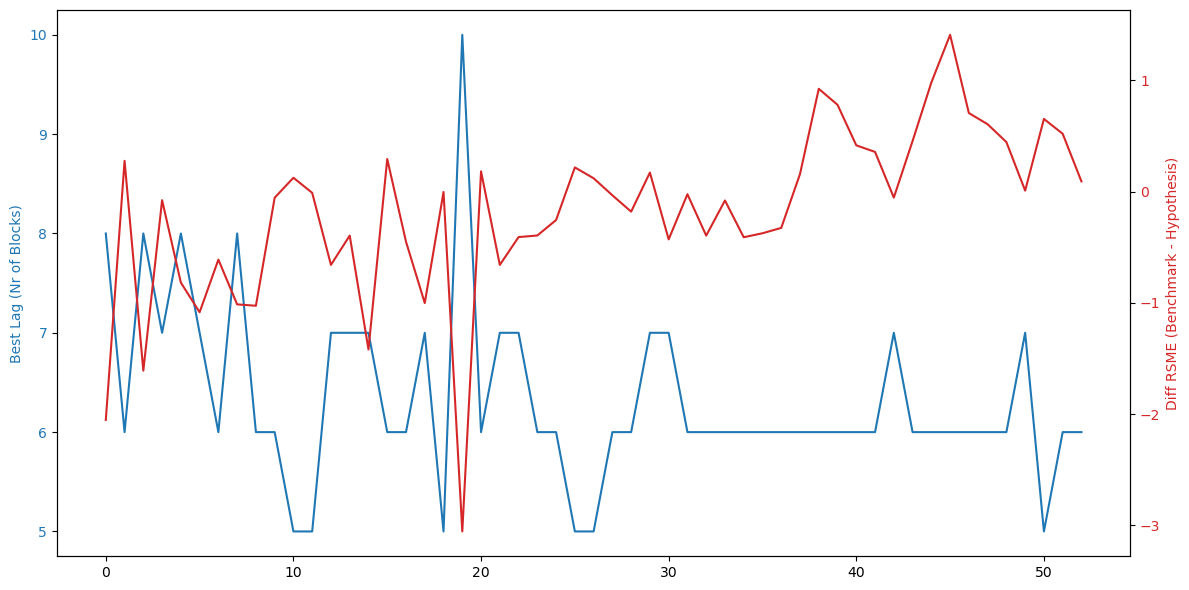

In [24]:
df = best_lags.copy()
df['bench_diff_rsme'] = df['bmrsme'] - df['rsme']

fig, ax1 = plt.subplots(figsize=(12, 6))

# plot 'best_lag' on the first y-axis
ax1.plot(df.index, df['best_lag'], color='tab:blue')
ax1.set_ylabel('Best Lag (Nr of Blocks)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# instantiate a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# plot 'bench_diff_rsme' on the second y-axis
ax2.plot(df.index, df['bench_diff_rsme'], color='tab:red')
ax2.set_ylabel('Diff RSME (Benchmark - Hypothesis)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()  # ensure right y-label is not clipped
plt.show()